In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, nbinom
from scipy.special import logsumexp

In [2]:
# ==========================================
# 1. CONFIGURATION & SIMULATION DU MODÈLE
# ==========================================
# Nous utilisons le "Stochastic Count Model" (Section 2.2.1 du papier)
# y_t ~ Poisson(h_t)
# h_t suit un processus Autoregressive Gamma

#np.random.seed(42)

class CoxProcessSimulation:
    def __init__(self, T, phi, nu, c):
        self.T = T
        self.phi = phi  # Autocorrélation (0 < phi < 1)
        self.nu = nu    # Forme (Shape)
        self.c = c      # Échelle (Scale)
        
    def simulate(self):
        h = np.zeros(self.T)
        y = np.zeros(self.T, dtype=int)
        z = np.zeros(self.T, dtype=int)
        
        # Initialisation h_0 (stationnaire approx)
        h[0] = np.random.gamma(self.nu, self.c)
        y[0] = np.random.poisson(h[0])
        
        for t in range(1, self.T):
            # Eq (3): z_t | h_{t-1} ~ Poisson(phi * h_{t-1} / c)
            lambda_z = (self.phi * h[t-1]) / self.c
            z[t] = np.random.poisson(lambda_z)
            
            # Eq (2): h_t | z_t ~ Gamma(nu + z_t, c)
            h[t] = np.random.gamma(self.nu + z[t], self.c)
            
            # Eq (1): y_t | h_t ~ Poisson(h_t)
            y[t] = np.random.poisson(h[t])
            
        return y, h, z

In [3]:
# Paramètres de simulation (Vérité terrain)
TRUE_PARAMS = {'phi': 0.8, 'nu': 2.5, 'c': 0.5}
T_sim = 3000

# Génération des données
sim = CoxProcessSimulation(T=T_sim, **TRUE_PARAMS)
y_obs, h_true, z_true = sim.simulate()

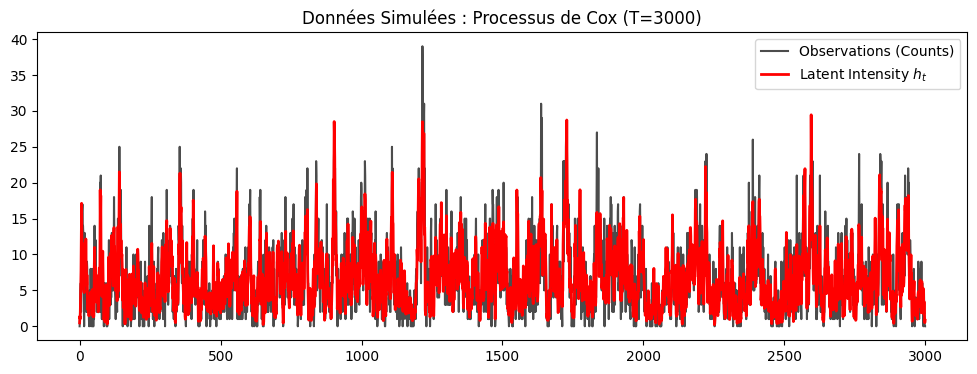

In [4]:
# Visualisation des données
plt.figure(figsize=(12, 4))
plt.plot(y_obs, label='Observations (Counts)', color='black', alpha=0.7)
plt.plot(h_true, label='Latent Intensity $h_t$', color='red', linewidth=2)
plt.title(f"Données Simulées : Processus de Cox (T={T_sim})")
plt.legend()
plt.show()

In [5]:
class ExactFilter:
    def __init__(self, y, Z_trunc=50):
        self.y = y
        self.T = len(y)
        self.Z = Z_trunc
        self.z_grid = np.arange(self.Z + 1)

    def log_likelihood(self, phi, nu, c):
        
        # ----- initial distribution p(z1) Eq (9) -----
        lambda_z1 = phi * nu / (1 - phi)
        log_p_z = poisson.logpmf(self.z_grid, lambda_z1)

        total_log_like = 0.0

        # ----- constants -----
        p_obs_scipy = 1.0 / (1.0 + c)   # Eq (12) but Scipy parameterization

        # NB parameter for transition Eq (13)
        p_nb_creal = phi / (1 + phi + c)
        p_scipy_trans = 1 - p_nb_creal   # convert to Scipy

        for t in range(self.T):

            # ============================================
            # 1. Mise à jour par l'observation Eq (12)
            # ============================================
            r_obs = nu + self.z_grid
            log_py_given_z = nbinom.logpmf(self.y[t], r_obs, p_obs_scipy)

            # p(y_t | y_{1:t-1})
            log_like_t = logsumexp(log_py_given_z + log_p_z)
            total_log_like += log_like_t

            # update log p(z_t | y_{1:t})
            log_p_z = log_py_given_z + log_p_z - log_like_t

            # ============================================
            # 2. Prédiction Eq (13)
            # ============================================
            if t < self.T - 1:
                y_prev = self.y[t]

                # r = nu + y_{t} + z_t
                r_trans = nu + y_prev + self.z_grid  # shape (Z+1)

                # Matrix of transitions p(z_{t+1}=j | z_t=i)
                # We want rows j, columns i
                # But we can use broadcasting:

                # r_trans: shape (Z+1,)
                # z_grid: shape (Z+1,)
                # log_trans[j,i] = nbinom.logpmf(z_j, r_trans[i], p_scipy_trans)

                log_trans = nbinom.logpmf(
                    self.z_grid[:, None],     # shape (Z+1,1)
                    r_trans[None, :],         # shape (1,Z+1)
                    p_scipy_trans
                )

                # prediction log p(z_{t+1})
                new_log_p_z = logsumexp(log_trans + log_p_z[None, :], axis=1)
                log_p_z = new_log_p_z

        return total_log_like


In [6]:
# ==========================================
# 3. IMPLEMENTATION DU FILTRE PARTICULAIRE (Bootstrap)
# ==========================================

class ParticleFilter:
    def __init__(self, y, N_particles=1000):
        self.y = y
        self.T = len(y)
        self.N = N_particles
        
    def log_likelihood(self, phi, nu, c):
        # Initialisation des particules
        h = np.random.gamma(nu, c, self.N)
        weights = np.ones(self.N) / self.N
        
        total_log_like = 0.0
        
        for t in range(self.T):
            # 1. Prédiction / Propagation
            # z_t ~ Poisson(phi * h_{t-1} / c)
            lambda_z = (phi * h) / c
            z_parts = np.random.poisson(lambda_z)
            
            # h_t ~ Gamma(nu + z_t, c)
            h_new = np.random.gamma(nu + z_parts, c)
            
            # 2. Pondération (Weighting)
            # w_i = p(y_t | h_t^i) = Poisson(y_t; h_t^i)
            log_weights = poisson.logpmf(self.y[t], h_new)
            
            # Estimation de la vraisemblance conditionnelle p(y_t | y_{1:t-1})
            # C'est la moyenne des poids non normalisés (méthode standard PF)
            max_log_w = np.max(log_weights)
            # Somme exp(log_w - max)
            sum_w = np.sum(np.exp(log_weights - max_log_w))
            log_like_t = max_log_w + np.log(sum_w) - np.log(self.N)
            
            total_log_like += log_like_t
            
            # Normalisation des poids pour le rééchantillonnage
            weights = np.exp(log_weights - max_log_w)
            weights /= np.sum(weights)
            
            # 3. Rééchantillonnage (Resampling - Systematic)
            indices = np.random.choice(np.arange(self.N), size=self.N, p=weights)
            h = h_new[indices]
            
        return total_log_like

In [7]:
# ==========================================
# 4. COMPARAISON DES PROFILS (Comme Figure 1)
# ==========================================
# On fait varier le paramètre phi autour de sa vraie valeur (0.8)

exact_filter = ExactFilter(y_obs, Z_trunc=50) #cf le plot au dessus où on voit que les données vont jusqu'à 33 max
particle_filter = ParticleFilter(y_obs, N_particles=10000) # N modéré pour voir le bruit


Calcul en cours des profils de vraisemblance...


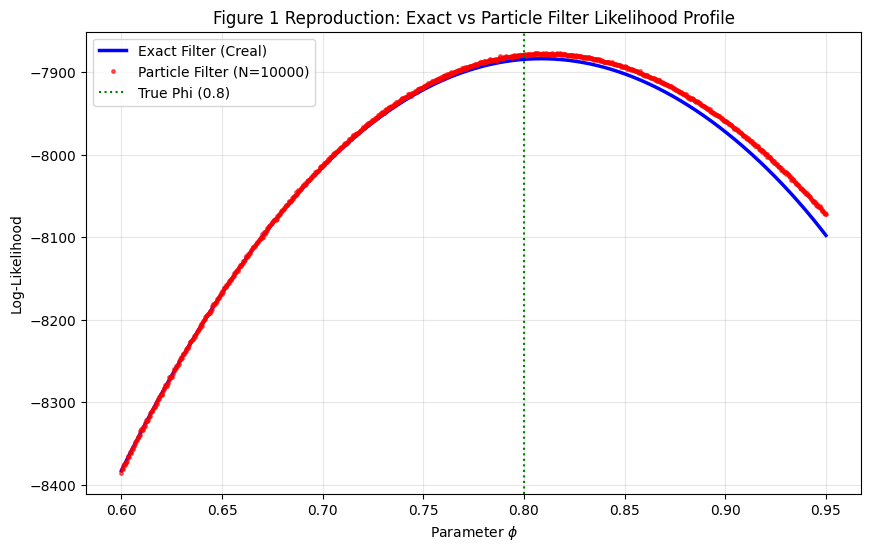

In [8]:

phi_grid = np.linspace(0.6, 0.95, 1000)
ll_exact = []
ll_pf = []

print("Calcul en cours des profils de vraisemblance...")

for p in phi_grid:
    np.random.seed(None)
    # Exact Filter
    ll_exact.append(exact_filter.log_likelihood(phi=p, nu=TRUE_PARAMS['nu'], c=TRUE_PARAMS['c']))
    
    # Particle Filter (Stochastique)
    ll_pf.append(particle_filter.log_likelihood(phi=p, nu=TRUE_PARAMS['nu'], c=TRUE_PARAMS['c']))

# Affichage
plt.figure(figsize=(10, 6))
plt.plot(phi_grid, ll_exact, label='Exact Filter (Creal)', color='blue', linewidth=2.5)
plt.plot(phi_grid, ll_pf, 
         label='Particle Filter (N=10000)', 
         color='red', 
         linestyle='None',   # <--- C'est ici : pas de ligne
         marker='.',         # Juste des points
         markersize=5,       # Taille des points
         alpha=0.6)
plt.axvline(x=TRUE_PARAMS['phi'], color='green', linestyle=':', label='True Phi (0.8)')
plt.xlabel(r'Parameter $\phi$')
plt.ylabel('Log-Likelihood')
plt.title('Figure 1 Reproduction: Exact vs Particle Filter Likelihood Profile')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Génération du nuage (N=10000, 5 répétitions par point)...


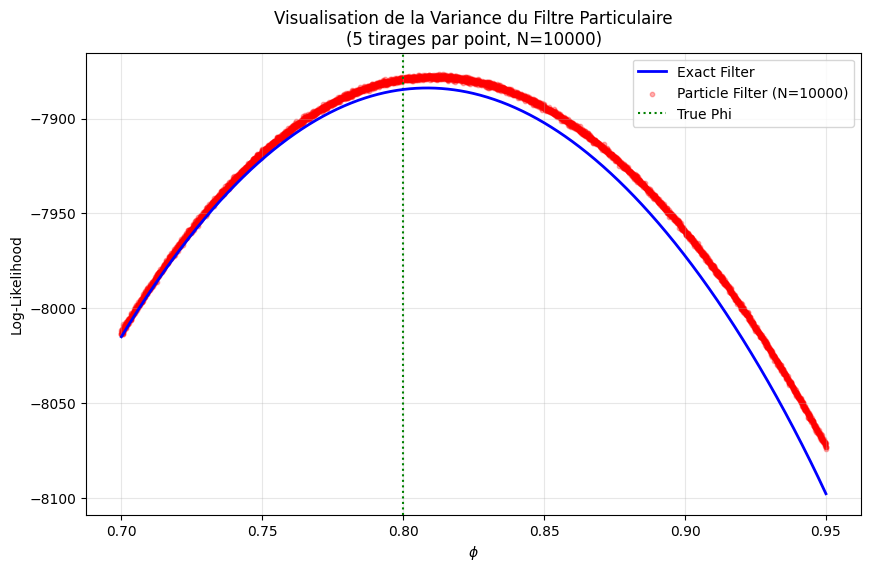

In [15]:
# --- Paramètres de la démo ---
# On réduit N juste pour l'image (pour augmenter le "bruit" visible)
N_demo = 10000
particle_filter.N = N_demo 

# On prend une grille moins serrée mais on va calculer PLUSIEURS fois par point
phi_grid_demo = np.linspace(0.7, 0.95, 1000) 
n_repeats = 5  # Nombre de répétitions par point de la grille (pour voir la dispersion)

ll_exact = []
phi_vals_scatter = [] # Pour stocker les X des points rouges
ll_pf_scatter = []    # Pour stocker les Y des points rouges

print(f"Génération du nuage (N={N_demo}, {n_repeats} répétitions par point)...")

# 1. Calcul de la courbe exacte (Bleue) - une seule fois suffit
for p in phi_grid_demo:
    ll_exact.append(exact_filter.log_likelihood(p, TRUE_PARAMS['nu'], TRUE_PARAMS['c']))
    
    # 2. Calcul du Filtre Particulaire (Rouge) - PLUSIEURS FOIS par phi
    for _ in range(n_repeats):
        np.random.seed(None) # S'assurer que l'aléatoire change bien
        val = particle_filter.log_likelihood(p, TRUE_PARAMS['nu'], TRUE_PARAMS['c'])
        
        # On stocke les paires (x, y) pour le scatter plot
        phi_vals_scatter.append(p)
        ll_pf_scatter.append(val)

# --- Affichage ---
plt.figure(figsize=(10, 6))

# Courbe exacte
plt.plot(phi_grid_demo, ll_exact, label='Exact Filter', color='blue', linewidth=2, zorder=5)

# Nuage de points dispersés
plt.scatter(phi_vals_scatter, ll_pf_scatter, 
            color='red', s=10, alpha=0.3, label=f'Particle Filter (N={N_demo})')

plt.axvline(x=TRUE_PARAMS['phi'], color='green', linestyle=':', label='True Phi')
plt.title(f'Visualisation de la Variance du Filtre Particulaire\n({n_repeats} tirages par point, N={N_demo})')
plt.xlabel(r'$\phi$')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
